## 03_train_baseline_model

In [16]:
# Import necessary libraries

import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix

BASE = '..'
INPUT = os.path.join(BASE, 'data', 'Nova_pay_features.csv')
MODELS = os.path.join(BASE, 'models')

# Load the data
df = pd.read_csv(INPUT, parse_dates=['timestamp'])
df = df.dropna(subset=['timestamp', 'is_fraud'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11139 entries, 0 to 11138
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   transaction_id             11139 non-null  object             
 1   customer_id                11139 non-null  object             
 2   timestamp                  11139 non-null  datetime64[ns, UTC]
 3   home_country               11139 non-null  object             
 4   source_currency            11139 non-null  object             
 5   dest_currency              11139 non-null  object             
 6   channel                    11139 non-null  object             
 7   amount_src                 11139 non-null  float64            
 8   amount_usd                 11139 non-null  float64            
 9   fee                        11139 non-null  float64            
 10  exchange_rate_src_to_dest  11139 non-null  float64            
 11  de

In [20]:
# Features
categorical = ['home_country','source_currency','dest_currency','channel','kyc_tier','ip_country']
bool_cols = ['new_device','location_mismatch', 'ip_country_missing']
numeric = ['amount_src','amount_usd','fee','ip_risk_score','device_trust_score','account_age_days','txn_velocity_1h','txn_velocity_24h','corridor_risk','risk_score_internal', 'hour', 'dayofweek']
for c in categorical:
    if c in df.columns:
        df[c] = df[c].astype("string").fillna("missing")

for c in bool_cols:
    if c in df.columns:
        df[c] = df[c].fillna(False).astype(bool)

### Data Spliting
#### This code performs a time-based split of the dataset into train/validation/test using rolling time windows. It sorts the data, get the most recent timestamp and define cutoffs
- training: data older than 270days **(>270DAYS)**
- Validation: data from 270 --> 180days agao  **270-180DAYS)**
- Test: most recent 180days  **(<180DAYS)**



In [23]:
df = df.sort_values('timestamp')
max_date = df['timestamp'].max()
valid_start = max_date - pd.Timedelta(days=270)
test_start = max_date - pd.Timedelta(days=180)

train_df = df[df['timestamp'] < valid_start]
valid_df = df[(df['timestamp'] >= valid_start) & (df['timestamp'] < test_start)]
test_df = df[df['timestamp'] >= test_start]

X_train = train_df[categorical + bool_cols + numeric]
y_train = train_df['is_fraud'].astype(int).values
X_valid = valid_df[categorical + bool_cols + numeric]
y_valid = valid_df['is_fraud'].astype(int).values
X_test = test_df[categorical + bool_cols + numeric]
y_test = test_df['is_fraud'].astype(int).values

print(f"Training: {len(train_df)} | Validation: {len(valid_df)} | Test: {len(test_df)}")

print("----Fraud Rate in each set----")
print(f"Train set:      {train_df['is_fraud'].mean() * 100:.2f}%")
print(f"Validation set: {valid_df['is_fraud'].mean() * 100:.2f}%")
print(f"Test set:       {test_df['is_fraud'].mean() * 100:.2f}%")

Training: 8817 | Validation: 1007 | Test: 1315
----Fraud Rate in each set----
Train set:      7.63%
Validation set: 11.02%
Test set:       15.89%


### Data Preprocessing

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        # One-hot econde categorical features
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical + bool_cols),
        
        # Standard scale numerical features
        ("num", StandardScaler(with_mean=False), numeric),
    ],
    remainder="drop"
)

### Train LogisticRegression and Ramdom Forest Model

In [29]:
# Logistic Regression

log_reg = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=None))
])

log_reg.fit(X_train, y_train)
y_prob_log_reg = log_reg.predict_proba(X_test)[:,1]

rf = Pipeline(steps=[
              ("prep", preprocessor),
              ("model", RandomForestClassifier(
                  n_estimators=300,
                  random_state=42,
                  class_weight="balanced_subsample",
                  n_jobs=-1
              ))
])

rf.fit(X_train, y_train)
y_prob_rf = rf.predict_proba(X_test)[:,1]

def metrics(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)

    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    roc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float("nan")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) else 0.0

    return {
        "threshold": float(thr),
        "precision": float(p),
        "recall": float(r),
        "f1": float(f1),
        "roc_auc": float(roc),
        "false_positive_rate": float(fpr),
        "confusion_matrix": [[int(tn), int(fp)], [int(fn), int(tp)]],
    }

res = {
    "samples": {
        "n_train": int(len(X_train)),
        "n_valid": int(len(X_valid)),
        "n_test": int(len(X_test)),
    },
    "test_metrics": {
        "logistic_regression": metrics(y_test, y_prob_log_reg, thr=0.5),
        "random_forest": metrics(y_test, y_prob_rf, thr=0.5),
    },
}
print(json.dumps(res, indent=2))

os.makedirs(MODELS, exist_ok=True)
joblib.dump(log_reg, os.path.join(MODELS, 'model_log_reg.joblib'))
joblib.dump(rf, os.path.join(MODELS, 'model_rf.joblib'))
with open(os.path.join(MODELS, 'metrics_baseline.json'),'w',encoding='utf-8') as f:
    json.dump(res, f, indent=2)

{
  "samples": {
    "n_train": 8817,
    "n_valid": 1007,
    "n_test": 1315
  },
  "test_metrics": {
    "logistic_regression": {
      "threshold": 0.5,
      "precision": 0.7803921568627451,
      "recall": 0.9521531100478469,
      "f1": 0.8577586206896551,
      "roc_auc": 0.9818562516763716,
      "false_positive_rate": 0.05063291139240506,
      "confusion_matrix": [
        [
          1050,
          56
        ],
        [
          10,
          199
        ]
      ]
    },
    "random_forest": {
      "threshold": 0.5,
      "precision": 0.9949238578680203,
      "recall": 0.937799043062201,
      "f1": 0.9655172413793104,
      "roc_auc": 0.9791243067392301,
      "false_positive_rate": 0.0009041591320072332,
      "confusion_matrix": [
        [
          1105,
          1
        ],
        [
          13,
          196
        ]
      ]
    }
  }
}


#### Both models show excellent discriminatory power (ROC-AUC ≈ 0.98).
#### Random Forest achieves near-zero false positives at default threshold, while Logistic Regression achieves slightly higher recall at the cost of higher customer friction.
#### Final model selection should be based on threshold optimization under a business-defined false-positive constraint.”

In [32]:
def print_model_summary(model_name, metrics_dict):
    print(f"🟢 {model_name} – Test Set Performance\n")
    print(f"Recall:              {metrics_dict['recall']*100:.1f}%  "
          f"→ missed {metrics_dict['confusion_matrix'][1][0]} frauds")
    print(f"Precision:           {metrics_dict['precision']*100:.1f}%")
    print(f"False Positive Rate: {metrics_dict['false_positive_rate']*100:.2f}% "
          f"({metrics_dict['confusion_matrix'][0][1]} false positives)")
    print(f"ROC-AUC:             {metrics_dict['roc_auc']:.3f}")
    print("-" * 55 + "\n")

# Extract metrics
lr_metrics = res["test_metrics"]["logistic_regression"]
rf_metrics = res["test_metrics"]["random_forest"]

# Print summaries
print_model_summary("Logistic Regression", lr_metrics)
print_model_summary("Random Forest", rf_metrics)

🟢 Logistic Regression – Test Set Performance

Recall:              95.2%  → missed 10 frauds
Precision:           78.0%
False Positive Rate: 5.06% (56 false positives)
ROC-AUC:             0.982
-------------------------------------------------------

🟢 Random Forest – Test Set Performance

Recall:              93.8%  → missed 13 frauds
Precision:           99.5%
False Positive Rate: 0.09% (1 false positives)
ROC-AUC:             0.979
-------------------------------------------------------



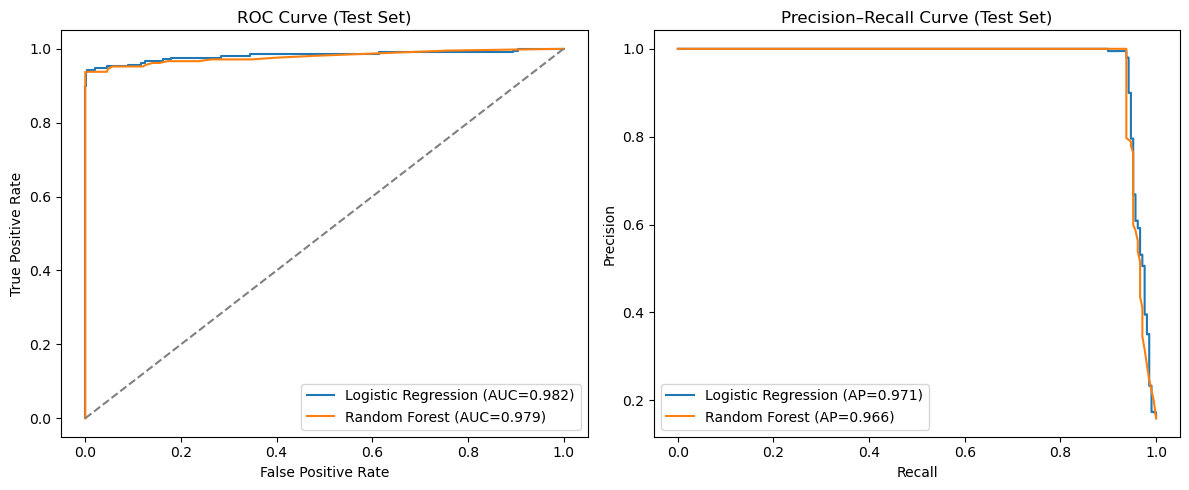

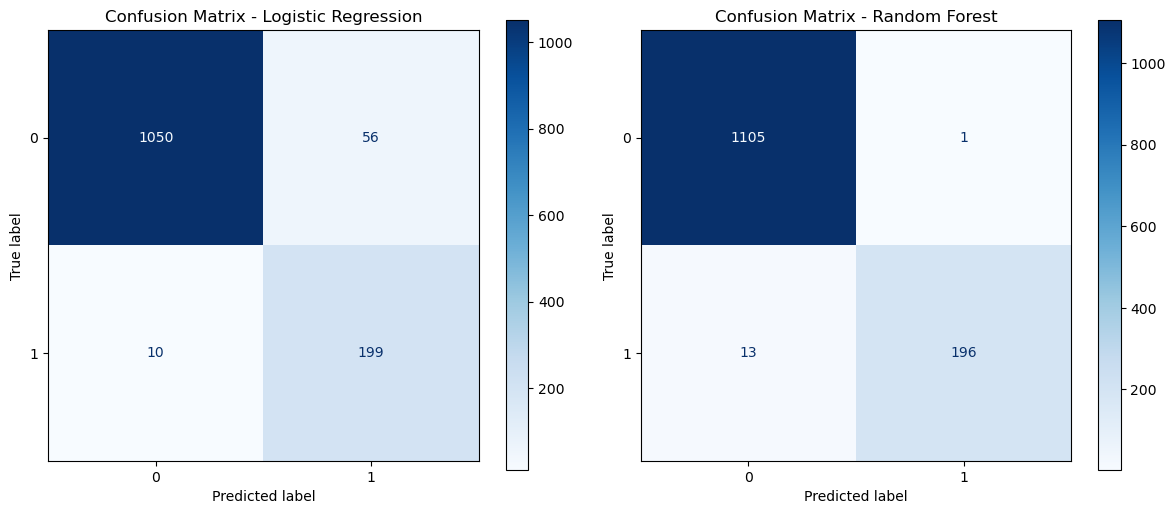

Saved model evaluation plots to ..\plots


In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, average_precision_score

PLOTS = os.path.join(BASE, 'plots')
os.makedirs(PLOTS, exist_ok=True)

thr = 0.5
models = {
    "Logistic Regression": {"y_prob": y_prob_log_reg, "thr": thr},
    "Random Forest": {"y_prob": y_prob_rf, "thr": thr},
}

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ROC
for name, d in models.items():
    fpr, tpr, _ = roc_curve(y_test, d["y_prob"])
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

axs[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axs[0].set_title("ROC Curve (Test Set)")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(loc="lower right")


# Precision–Recall Curve
for name, d in models.items():
    precision, recall, _ = precision_recall_curve(y_test, d["y_prob"])
    ap = average_precision_score(y_test, d["y_prob"])
    axs[1].plot(recall, precision, label=f"{name} (AP={ap:.3f})")

axs[1].set_title("Precision–Recall Curve (Test Set)")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend(loc="lower left")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS, "roc_pr_curves.png"), dpi=200)
plt.show()

# Confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(12,5))

for ax, (name, d) in zip(axs, models.items()):
    y_pred = (d["y_prob"] >= d["thr"]).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, values_format="d", cmap='Blues')
    ax.set_title(f"Confusion Matrix - {name}")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS, "confusion_matrices.png"), dpi=200)
plt.show()

print('Saved model evaluation plots to', PLOTS)

#### A downward-sloping precision–recall curve is expected because increasing recall requires lowering the threshold, which inevitably introduces more false positives and reduces precision.
#### The LR model only missed 10 fraud cases, but flags many legitimate users - 56 false positive. However, the RF model flagged 1 legitimate user - 1 false positive, but still catches most fraud (only missed 13 fraud cases)